### Controlled: Average value

Fixed:  Grid size, Autocorrlation

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shapely import geometry as geom
import geopandas as gpd


In [2]:
def create_queen_adjacency(n):
    """
    Create a queen adjacency matrix for an n x n grid.
    Each cell is connected to its 8 adjacent neighbors (N, S, E, W, NE, NW, SE, SW).
    
    Parameters:
    -----------
    n : int
        Size of the grid (n x n)
        
    Returns:
    --------
    W : scipy.sparse.csr_matrix
        Sparse adjacency matrix (n² x n²)
    """
    W = sp.lil_matrix((n * n, n * n))
    for row in range(n):
        for col in range(n):
            idx = row * n + col
            
            # Cardinal directions (same as rook)
            if row > 0:  # North
                W[idx, (row - 1) * n + col] = 1
            if row < n - 1:  # South
                W[idx, (row + 1) * n + col] = 1
            if col > 0:  # West
                W[idx, row * n + (col - 1)] = 1
            if col < n - 1:  # East
                W[idx, row * n + (col + 1)] = 1
                
            # Diagonal connections (unique to queen)
            if row > 0 and col > 0:  # Northwest
                W[idx, (row - 1) * n + (col - 1)] = 1
            if row > 0 and col < n - 1:  # Northeast
                W[idx, (row - 1) * n + (col + 1)] = 1
            if row < n - 1 and col > 0:  # Southwest
                W[idx, (row + 1) * n + (col - 1)] = 1
            if row < n - 1 and col < n - 1:  # Southeast
                W[idx, (row + 1) * n + (col + 1)] = 1
    
    # Return as CSR format for efficient operations
    return W.tocsr()

In [3]:
def row_standardize_sparse(W):
    """
    Row-standardize a sparse matrix efficiently.
    """
    W_csr = W.tocsr()
    row_sums = np.array(W_csr.sum(axis=1)).flatten()
    # Handle zero row sums to avoid division by zero
    # row_sums[row_sums == 0] = 1
    
    # Create diagonal matrix with inverse of row sums
    D_inv = sp.diags(1.0 / row_sums)
    
    # Multiply to get row-standardized matrix
    W_std = D_inv @ W_csr
    return W_std

In [4]:
def simulate_sar_fixed_mean(W, rho, fixed_mean=0.15, sigma=1.0, random_seed=None):
    """
    Simulate a Spatial Autoregressive (SAR) process with a fixed mean.
    
    Model: y = (I - ρW)^(-1) * ε
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = W.shape[0]
    I = sp.identity(n, format='csr')
    
    # Generate random error terms
    epsilon = np.random.normal(0, sigma, size=n)
    
    # Calculate (I - ρW)^(-1)
    A_inv = inv((I - rho * W).toarray())
    
    # Compute SAR process: y = (I - ρW)^(-1) * ε
    y = A_inv @ epsilon
    
    # Adjust to the target mean while preserving variance structure
    y = y - np.mean(y) + fixed_mean
    
    return y

In [5]:
def create_dfs_for_simulations(simulations, fixed_means, n, fixed_rho):
    """
    Create a DataFrame for each simulation result.
    """
    geodataframes = {}
    df_index = pd.DataFrame({'Index': np.arange(n**2)})

    def calculate_square_coordinates(row, n):
        value = row['Index']
        x = value % n
        y = value // n
        return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])
    
    df_index['geometry'] = df_index.apply(lambda row: calculate_square_coordinates(row, n), axis=1)
    
    for mean in fixed_means:
        temp_df = df_index.copy()
        temp_df['Value'] = simulations[mean]
        temp_df['rho'] = fixed_rho
        temp_df['mean'] = mean

        temp_gdf = gpd.GeoDataFrame(temp_df, geometry='geometry')
        geodataframes[mean] = temp_gdf
    
    return geodataframes

In [ ]:
# def visualize_varying_means(simulations, n, fixed_means, fixed_rho, cmap='coolwarm'):
#     """
#     Visualize spatial patterns with different mean values but fixed autocorrelation.
#     """
#     # Number of columns in the grid
#     ncols = min(5, len(fixed_means))
#     # Number of rows needed
#     nrows = (len(fixed_means) + ncols - 1) // ncols
    
#     fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
#     axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    
#     # Find global min and max for consistent color scaling
#     vmin = min(sim.min() for sim in simulations.values())
#     vmax = max(sim.max() for sim in simulations.values())
    
#     for i, mean in enumerate(fixed_means):
#         if i < len(axs):
#             sim_data = simulations[mean].reshape((n, n))
#             im = axs[i].imshow(sim_data, cmap=cmap, vmin=vmin, vmax=vmax)
#             # axs[i].set_title(f"Mean = {mean:.2f}\nActual Mean = {simulations[mean].mean():.3f}")
#             axs[i].axis('off')
    
#     # Hide any unused axes
#     for i in range(len(fixed_means), len(axs)):
#         axs[i].axis('off')
    
#     # Add colorbar
#     cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    
#     # plt.suptitle(f"Spatial Patterns with Fixed Autocorrelation (ρ = {fixed_rho}) and Varying Means", fontsize=16)
#     plt.tight_layout(rect=[0, 0, 0.9, 0.95])
#     return fig

In [26]:
def visualize_varying_means(simulations, n, fixed_means, fixed_rho, cmap='coolwarm'):
    """
    Visualize spatial patterns with different mean values but fixed autocorrelation.
    """
    # Number of columns in the grid
    ncols = min(5, len(fixed_means))
    # Number of rows needed
    nrows = (len(fixed_means) + ncols - 1) // ncols
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    
    # Find global min and max for consistent color scaling
    vmin = min(sim.min() for sim in simulations.values())
    vmax = max(sim.max() for sim in simulations.values())
    
    for i, mean in enumerate(fixed_means):
        if i < len(axs):
            sim_data = simulations[mean].reshape((n, n))
            im = axs[i].imshow(sim_data, cmap=cmap, vmin=vmin, vmax=vmax)
            # axs[i].set_title(f"Mean = {mean:.2f}\nActual Mean = {simulations[mean].mean():.3f}")
            axs[i].axis('off')
            
            # Add subplot labels (a), (b), etc. at the bottom
            subplot_label = f"({chr(97+i)})"  # 97 is ASCII for 'a'
            axs[i].text(0.5, -0.05, subplot_label, transform=axs[i].transAxes, 
                       ha='center', va='top', fontsize=14)
    
    # Hide any unused axes
    for i in range(len(fixed_means), len(axs)):
        axs[i].axis('off')
    
    # Add colorbar but move it to bottom to avoid interfering with subplot labels
    # cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])  # [left, bottom, width, height]
    # fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    
    # plt.suptitle(f"Spatial Patterns with Fixed Autocorrelation (ρ = {fixed_rho}) and Varying Means", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    return fig

Main execution


In [27]:
# Import the TDA utilities needed
from utills.adjacency_simplex import AdjacencySimplex 
from utills.calculate_tda_summaries import compute_persistence

In [28]:
# Parameters
n = 12  # Grid size
fixed_rho = 0.7  # Fixed autocorrelation level
sigma = 1.0
random_seed = 42

# Create and standardize the adjacency matrix
W = create_queen_adjacency(n)
W_std = row_standardize_sparse(W)

# Vary the mean values
# fixed_means = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
fixed_means = [-3.0, -1.5, 0.0, 1.5, 3.0]  # Example means for testing

# Simulate for each mean value
simulations = {
    mean: simulate_sar_fixed_mean(W_std, fixed_rho, fixed_mean=mean, 
                                  sigma=sigma, random_seed=random_seed) 
    for mean in fixed_means
}

In [29]:
# Create GeoDataFrames for each simulation
geo_dataframes = create_dfs_for_simulations(simulations, fixed_means, n, fixed_rho)

In [30]:
# Calculate TDA summaries for each mean value
results_df = pd.DataFrame(columns=['Mean', 'Filter Method', 'TL', 'AL', 'TML', 'AML', 'Actual_Mean'])

In [31]:
for mean in fixed_means:
    gdf = geo_dataframes[mean]
    actual_mean = gdf['Value'].mean()
    
    # Calculate TDA summaries with downward filtration
    adj_simplex = AdjacencySimplex(gdf, 'Value', threshold=None, filter_method='down')
    filtered_df, gdf_id = adj_simplex.filter_sort_gdf()
    adj_simplex.calculate_adjacent_countries()
    simplex = adj_simplex.form_simplicial_complex()
    _, TL, AL, TML, AML, _ = compute_persistence(simplices=simplex, filtered_df=filtered_df, variable_name='Value')
    
    # Add results to DataFrame
    new_row = pd.DataFrame({
        'Mean': [mean],
        'Filter Method': ['down'],
        'TL': [TL],
        'AL': [AL],
        'TML': [TML],
        'AML': [AML],
        'Actual_Mean': [actual_mean]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)

In [32]:
results_df

,Mean,Filter Method,TL,AL,TML,AML,Actual_Mean
0,-3.0,down,435.774247,3.02621,217.887123,1.513105,-3.000000e+00
1,-1.5,down,435.774247,3.02621,217.887123,1.513105,-1.500000e+00
2,0.0,down,435.774247,3.02621,217.887123,1.513105,1.233581e-17
3,1.5,down,435.774247,3.02621,217.887123,1.513105,1.500000e+00
4,3.0,down,435.774247,3.02621,217.887123,1.513105,3.000000e+00


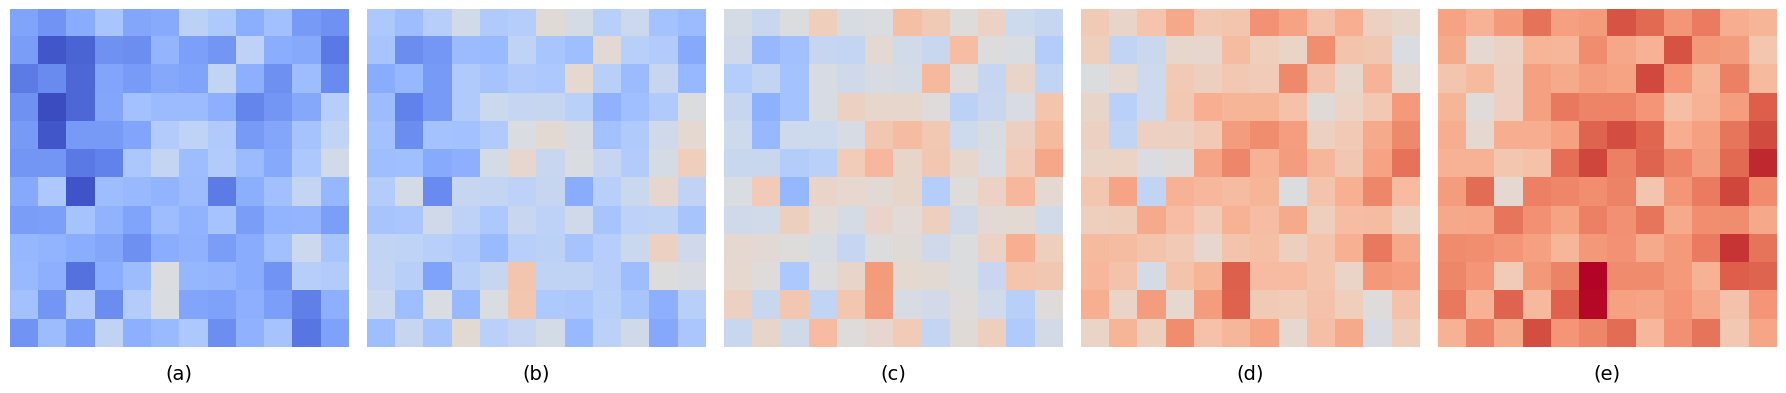

In [33]:
# Visualize the spatial patterns
fig_patterns = visualize_varying_means(simulations, n, fixed_means, fixed_rho)
# plt.savefig('spatial_patterns_varying_means.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

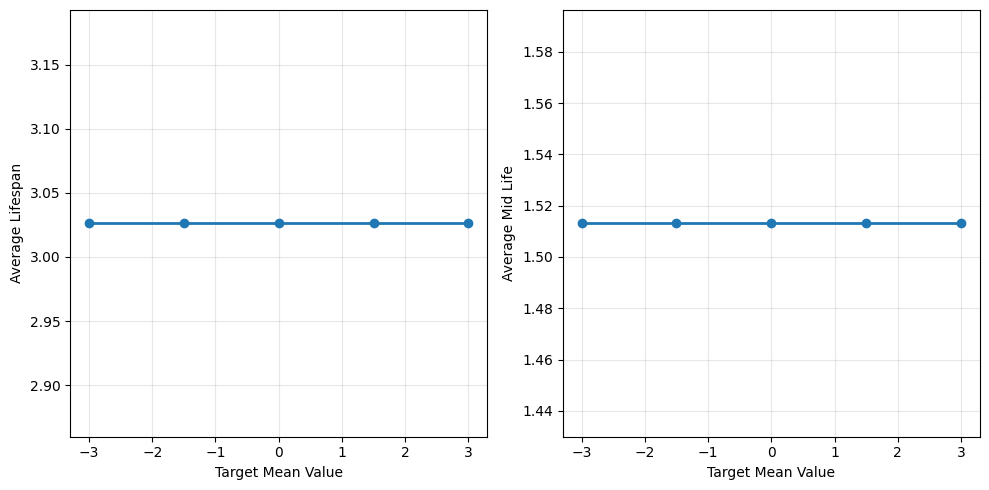

In [25]:
# Plot TDA summaries vs mean values
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

measures = ['AL', 'AML']
titles = ['Average Lifespan', 'Average Mid Life']

for i, (measure, title) in enumerate(zip(measures, titles)):
    axes[i].plot(results_df['Mean'], results_df[measure], marker='o', linestyle='-', linewidth=2)
    axes[i].set_xlabel('Target Mean Value')
    axes[i].set_ylabel(title)
    # axes[i].set_title(f'{title} vs Mean Value (ρ = {fixed_rho})')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('tda_measures_vs_mean.png', dpi=300)
plt.show()
plt.close()

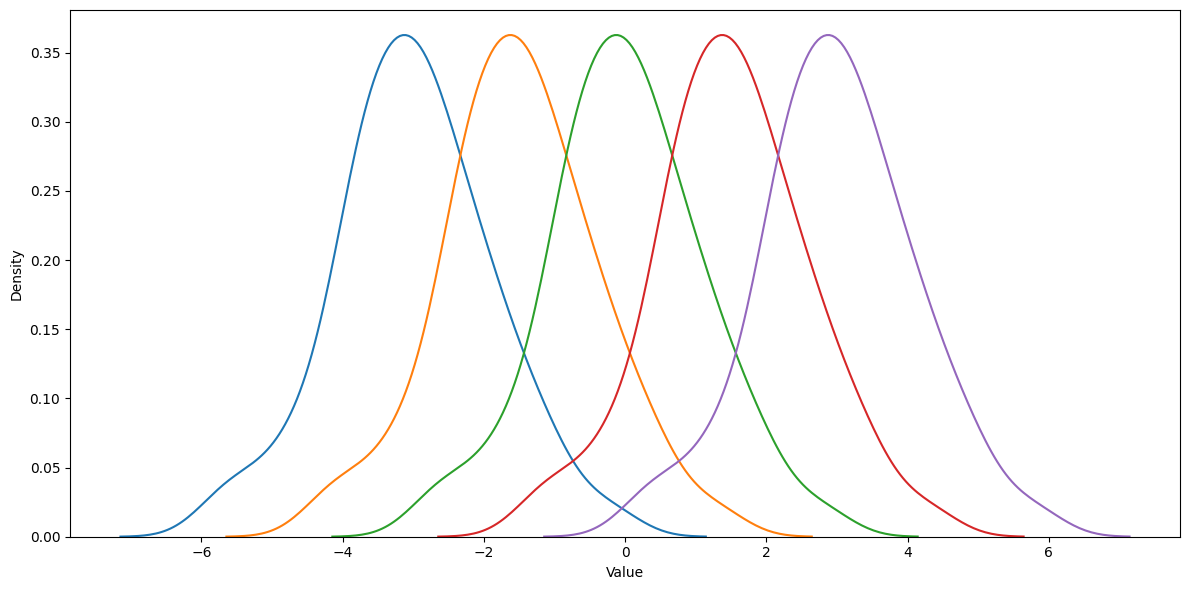

In [16]:
# Plot distributions of simulated values
plt.figure(figsize=(12, 6))
for mean in fixed_means:
    sns.kdeplot(simulations[mean], label=f"Mean = {mean}")

# plt.title(f"Distribution of Values Across Different Mean Values (ρ = {fixed_rho})")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.legend()
plt.tight_layout()
# plt.savefig('distributions_varying_means.png', dpi=300)
plt.show()
plt.close()

# Save results to CSV
# results_df.to_csv('tda_results_varying_means.csv', index=False)

# print(results_df)
# print("\nAnalysis complete. Results saved to CSV and plots saved as PNG files.")